In [1]:
import pandas as pd
import numpy as np


# 读取数据
train = pd.read_csv('train_smooth_all.csv')


KeyboardInterrupt: 

In [ ]:
train.isnull().sum()

total_orders                               0
sell_price_main                            0
holiday                                    0
shops_closed                               0
winter_school_holidays                     0
school_holidays                            0
month_sin                                  0
month_cos                                  0
day_sin                                    0
day_cos                                    0
year_mean                                  0
name_mean                                  0
warehouse_mean                             0
holiday_name_mean                          0
L1_category_name_en_mean                   0
L2_category_name_en_mean                   0
L3_category_name_en_mean                   0
L4_category_name_en_mean                   0
is_discount                                0
max_discount                               0
warehouse_Budapest_1                       0
warehouse_Frankfurt_1                      0
warehouse_

In [ ]:
train['date'] = pd.to_datetime(train['date'])
# 定义验证集的日期范围
val_start_date1 = pd.to_datetime('2023-06-03')
val_end_date1 = pd.to_datetime('2023-06-16')

val_start_date2 = pd.to_datetime('2024-05-03')
val_end_date2 = pd.to_datetime('2024-06-03')

# 划分第一个验证集
val1 = train[(train['date'] >= val_start_date1) & (train['date'] <= val_end_date1)]  # 2023-06-03 到 2023-06-16 的数据

# 划分第二个验证集
val2 = train[(train['date'] >= val_start_date2) & (train['date'] <= val_end_date2)]  # 2024-05-03 到 2024-06-03 的数据

# 合并两个验证集
val = pd.concat([val1, val2])

# 划分训练集
# 训练集是除了两个验证集之外的数据
train_before_val1 = train[train['date'] < val_start_date1]  # 第一个验证集之前的数据
train_between_vals = train[(train['date'] > val_end_date1) & (train['date'] < val_start_date2)]  # 两个验证集之间的数据
train_after_val2 = train[train['date'] > val_end_date2]  # 第二个验证集之后的数据

# 合并训练集
train = pd.concat([train_before_val1, train_between_vals, train_after_val2])

# 检查数据量
print("训练集数据量：", len(train))
print("验证集数据量：", len(val))

训练集数据量： 3853808
验证集数据量： 153559


In [4]:
train.shape,val.shape

((3853808, 35), (153559, 35))

In [5]:
train_date = train['date']
val_date = val['date']
train.drop(['unique_id','date'], axis=1, inplace=True)
val.drop(['unique_id','date'], axis=1, inplace=True)

In [6]:
y_train = train['sales']
y_val = val['sales']
train = train.drop(columns=['sales'])
val = val.drop(columns=['sales'])

In [7]:
y_train

1          12.63
2          34.55
3          34.52
4          35.92
6           6.39
           ...  
4007362    26.56
4007363    27.42
4007364    33.39
4007365    22.88
4007366    32.10
Name: sales, Length: 3853808, dtype: float64

In [8]:
import xgboost as xgb
# 将数据转换为 DMatrix 格式（XGBoost 的高效数据结构）
dtrain = xgb.DMatrix(train, label=y_train)
dval = xgb.DMatrix(val, label=y_val)

# 设置参数
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.015,
    'max_depth': 20,
    'min_child_weight': 5,
    'gamma': 5,
    'alpha': 1,
    'lambda': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'device': 'cuda',
    'max_bin': 512,  # 设置最大分桶数量
    'n_jobs': -1,
    'seed': 42
}

# 训练模型
model = xgb.train(
    params,
    dtrain,
    num_boost_round=560,
    evals=[(dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=20
)

[0]	validation-rmse:387.58218
[20]	validation-rmse:298.29117
[40]	validation-rmse:231.18927
[60]	validation-rmse:181.27159
[80]	validation-rmse:145.03930
[100]	validation-rmse:118.62373
[120]	validation-rmse:101.35841
[140]	validation-rmse:88.81947
[160]	validation-rmse:81.16727
[180]	validation-rmse:75.68837
[200]	validation-rmse:72.31964
[220]	validation-rmse:70.27049
[240]	validation-rmse:68.99287
[260]	validation-rmse:68.23743
[280]	validation-rmse:67.71046
[300]	validation-rmse:67.35349
[320]	validation-rmse:67.05468
[340]	validation-rmse:66.87405
[360]	validation-rmse:66.75290
[380]	validation-rmse:66.68947
[400]	validation-rmse:66.60962
[420]	validation-rmse:66.53936
[440]	validation-rmse:66.52777
[460]	validation-rmse:66.49882
[480]	validation-rmse:66.46359
[499]	validation-rmse:66.48195


In [9]:
# import pickle
# import xgboost as xgb
# # 保存模型（可选）
# model.save_model('xgboost_train.model')

# with open("xgboost_train.pkl", "wb") as file:
#     pickle.dump(model, file)

In [7]:
import xgboost as xgb
# 加载模型
model = xgb.Booster()
model.load_model('xgboost_xgb4.model')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
dval = xgb.DMatrix(val, label=y_val)
# 在验证集上进行预测
y_pred = model.predict(dval)

mae = mean_absolute_error(y_val, y_pred)
print(f'MAE: {mae}')

# 计算均方误差 (MSE)
mse = mean_squared_error(y_val, y_pred)
print(f'MSE: {mse}')

# 计算 R² (决定系数)
r2 = r2_score(y_val, y_pred)
print(f'R² Score: {r2}')

# 输出预测结果
print('Predictions:', y_pred)

MAE: 9.668915178407792
MSE: 294.22458828169016
R² Score: 0.9980961991545662
Predictions: [ 22.628656  24.775259  23.132732 ... 156.39038  139.59442  212.21603 ]


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 计算分位数
bins = np.quantile(y_val, [0.33, 0.66])

# 将目标变量分为低、中、高三个区间
y_val_binned = np.digitize(y_val, bins)

# 输出区间范围
print(f'Low range: y_val < {bins[0]:.2f}')
print(f'Mid range: {bins[0]:.2f} <= y_val < {bins[1]:.2f}')
print(f'High range: y_val >= {bins[1]:.2f}')

# 计算每个区间的 MAE
for i in range(3):
    mask = y_val_binned == i
    mae = mean_absolute_error(y_val[mask], y_pred[mask])
    print(f'MAE for bin {i}: {mae:.2f}')


Low range: y_val < 24.80
Mid range: 24.80 <= y_val < 66.39
High range: y_val >= 66.39
MAE for bin 0: 4.83
MAE for bin 1: 7.14
MAE for bin 2: 16.82


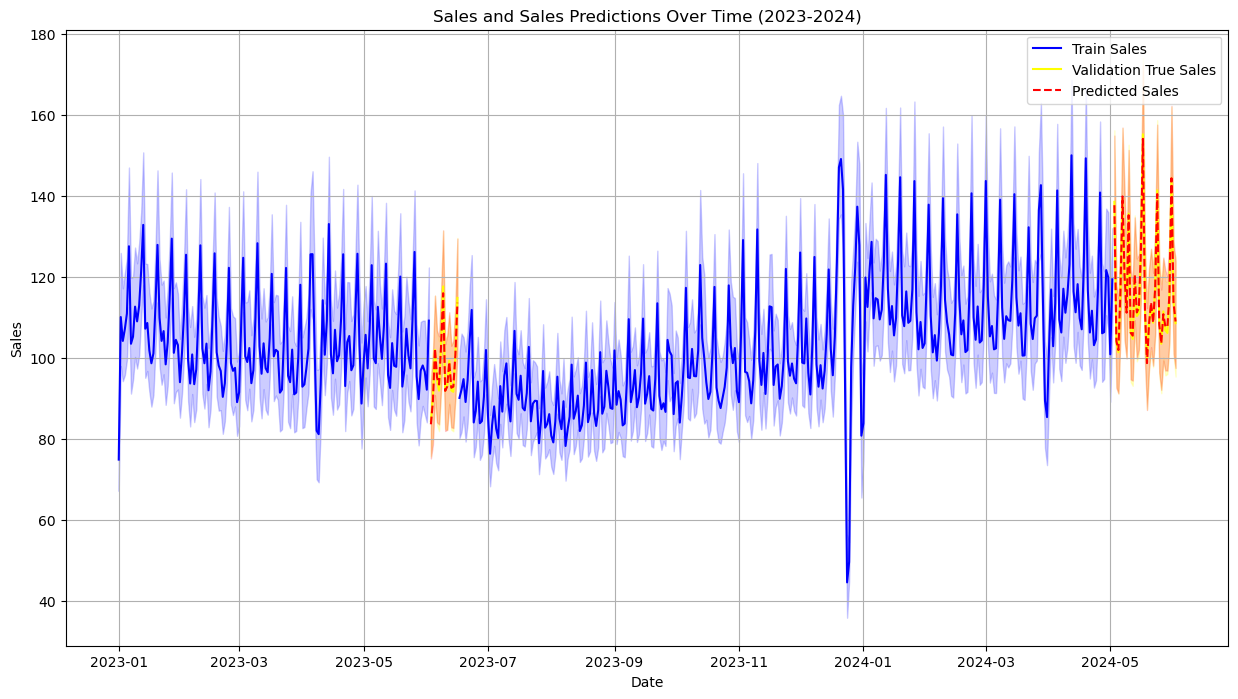

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 定义验证集的日期范围
val_start_date1 = pd.to_datetime('2023-06-03')
val_end_date1 = pd.to_datetime('2023-06-16')

val_start_date2 = pd.to_datetime('2024-05-03')
val_end_date2 = pd.to_datetime('2024-06-03')

train['date'] = train_date
val['date'] = val_date

train['sales'] = y_train
val['sales'] = y_val
# 确保 train 和 val 的 date 列是 datetime 类型
train['date'] = pd.to_datetime(train['date'])
val['date'] = pd.to_datetime(val['date'])

# 将预测值添加到验证集中
val['sales_hat'] = y_pred

# 划分训练集为多个部分
train_before_val1 = train[train['date'] < val_start_date1]  # 第一个验证集之前的数据
train_between_vals = train[(train['date'] > val_end_date1) & (train['date'] < val_start_date2)]  # 两个验证集之间的数据
train_after_val2 = train[train['date'] > val_end_date2]  # 第二个验证集之后的数据

# 划分验证集为多个部分
val1 = val[(val['date'] >= val_start_date1) & (val['date'] <= val_end_date1)]  # 第一个验证集
val2 = val[(val['date'] >= val_start_date2) & (val['date'] <= val_end_date2)]  # 第二个验证集

# 仅保留 2023 年和 2024 年的数据
train_before_val1 = train_before_val1[train_before_val1['date'].dt.year.isin([2023, 2024])]
train_between_vals = train_between_vals[train_between_vals['date'].dt.year.isin([2023, 2024])]
train_after_val2 = train_after_val2[train_after_val2['date'].dt.year.isin([2023, 2024])]
val1 = val1[val1['date'].dt.year.isin([2023, 2024])]
val2 = val2[val2['date'].dt.year.isin([2023, 2024])]

# 绘制图形
plt.figure(figsize=(15, 8))

# 绘制第一个验证集之前训练集的实际销售数据（蓝色）
sns.lineplot(data=train_before_val1, x='date', y='sales', color='blue', label='Train Sales ')

# 绘制两个验证集之间训练集的实际销售数据（蓝色）
sns.lineplot(data=train_between_vals, x='date', y='sales', color='blue')

# 绘制第二个验证集之后训练集的实际销售数据（蓝色）
sns.lineplot(data=train_after_val2, x='date', y='sales', color='blue')

# 绘制第一个验证集的实际销售数据（黄色）
sns.lineplot(data=val1, x='date', y='sales', color='yellow', label='Validation True Sales')

# 绘制第二个验证集的实际销售数据（黄色）
sns.lineplot(data=val2, x='date', y='sales', color='yellow')

# 绘制第一个验证集的预测销售数据（红色虚线）
sns.lineplot(data=val1, x='date', y='sales_hat', color='red', linestyle='--', label='Predicted Sales')

# 绘制第二个验证集的预测销售数据（红色虚线）
sns.lineplot(data=val2, x='date', y='sales_hat', color='red', linestyle='--')

# 添加标题和标签
plt.title('Sales and Sales Predictions Over Time (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

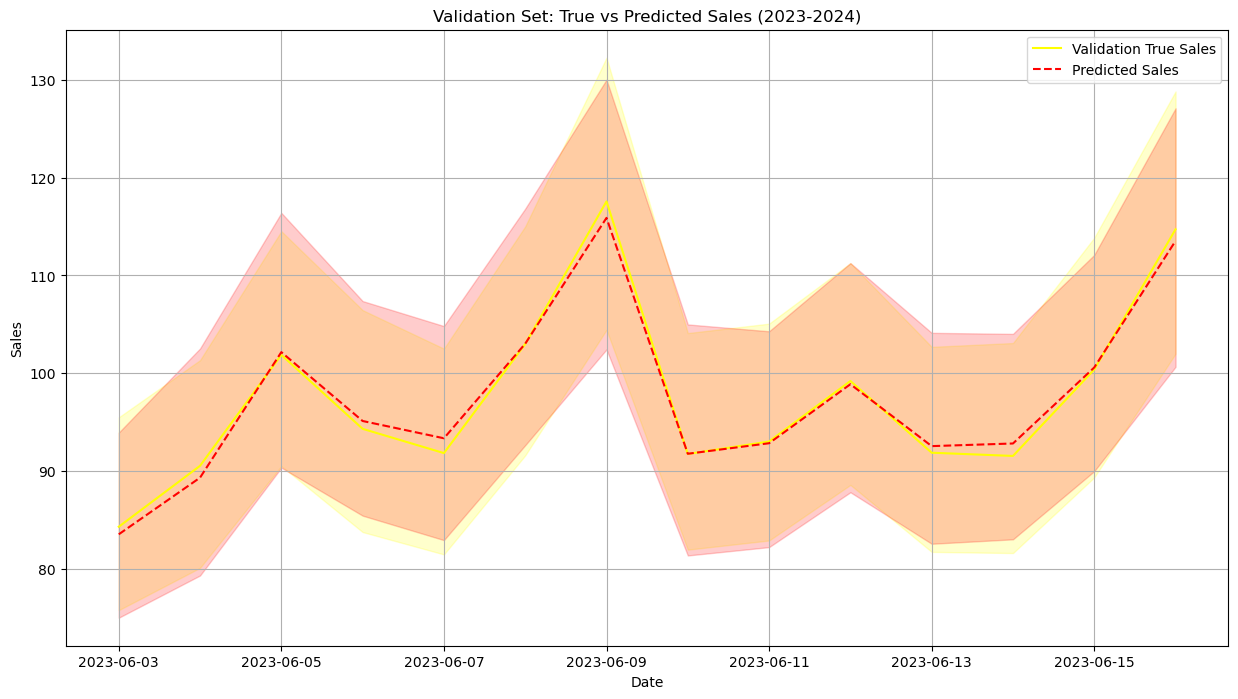

In [ ]:
# 绘制图形
plt.figure(figsize=(15, 8))

# 绘制第一个验证集的实际销售数据（黄色）
sns.lineplot(data=val1, x='date', y='sales', color='yellow', label='Validation True Sales')

# 绘制第一个验证集的预测销售数据（红色虚线）
sns.lineplot(data=val1, x='date', y='sales_hat', color='red', linestyle='--', label='Predicted Sales')

# 添加标题和标签
plt.title('Validation Set: True vs Predicted Sales (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

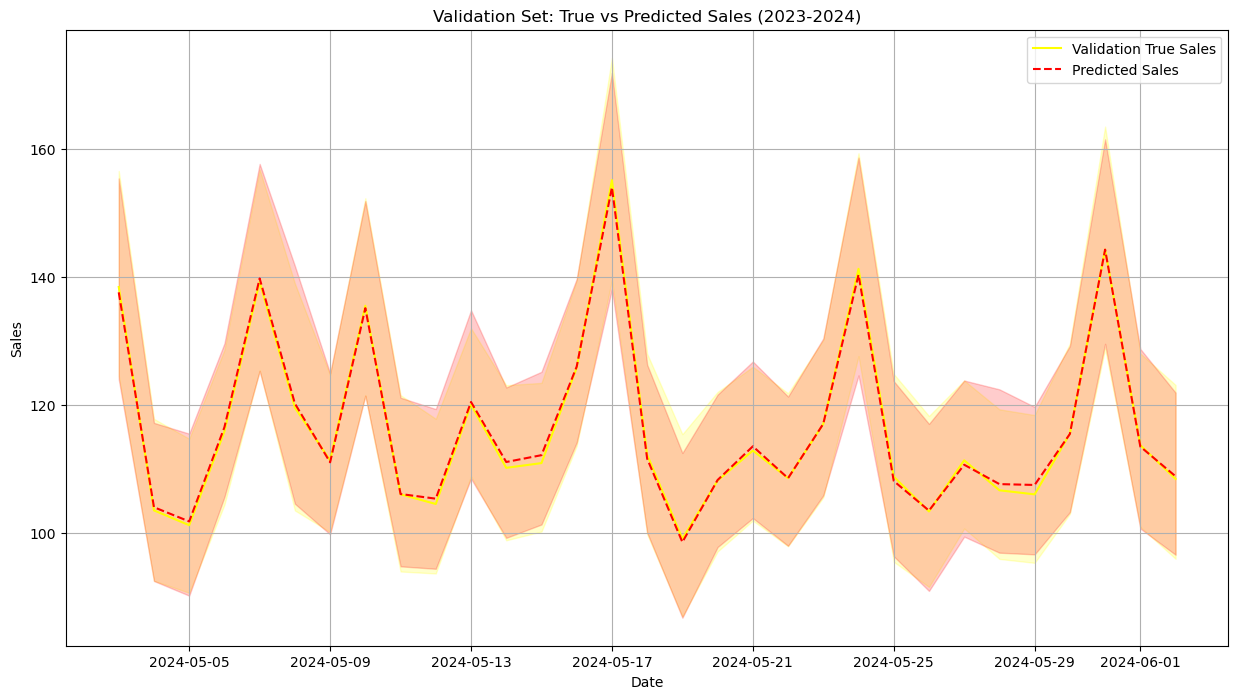

In [ ]:
# 绘制图形
plt.figure(figsize=(15, 8))

# 绘制第二个验证集的实际销售数据（黄色）
sns.lineplot(data=val2, x='date', y='sales', color='yellow', label='Validation True Sales')

# 绘制第二个验证集的预测销售数据（红色虚线）
sns.lineplot(data=val2, x='date', y='sales_hat', color='red', linestyle='--', label='Predicted Sales')

# 添加标题和标签
plt.title('Validation Set: True vs Predicted Sales (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()